In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

from funcoes_ajuda import descritiva

In [6]:
titanic = pd.read_pickle('/home/usp-ds-arnem/data/titanic.pkl')

In [31]:
titanic.head()

,Unnamed: 0,survived,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
0,0,0,3,22.0,1,0,7.2500,True,False,True
1,1,1,1,38.0,1,0,71.2833,False,False,False
2,2,1,3,26.0,0,0,7.9250,False,False,True
3,3,1,1,35.0,1,0,53.1000,False,False,True
4,4,0,3,35.0,0,0,8.0500,True,False,True


In [32]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  891 non-null    int64  
 1   survived    891 non-null    int64  
 2   pclass      891 non-null    int64  
 3   age         891 non-null    float64
 4   sibsp       891 non-null    int64  
 5   parch       891 non-null    int64  
 6   fare        891 non-null    float64
 7   sex_male    891 non-null    bool   
 8   embarked_Q  891 non-null    bool   
 9   embarked_S  891 non-null    bool   
dtypes: bool(3), float64(2), int64(5)
memory usage: 51.5 KB


In [7]:
# Verificar valores ausentes
print(titanic.isnull().sum())

Unnamed: 0    0
survived      0
pclass        0
age           0
sibsp         0
parch         0
fare          0
sex_male      0
embarked_Q    0
embarked_S    0
dtype: int64


Split train / test

In [8]:
# Separar variáveis preditoras e resposta
X = titanic.drop('survived', axis=1)
y = titanic['survived']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2360873)

# Sempre importante conferir a cada passo!
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(712, 9)
(712,)
(179, 9)
(179,)


Grid Search + XGB

In [22]:
# Parmâmetros
param_grid = {
    'n_estimators': [50, 100, 150], # How many trees to build.
    'max_depth': [2, 3], # How deep each tree can grow
    'gamma': [0], # How conservative the tree splits should be
    'learning_rate': [0.1, 0.4], # How much each tree contributes to the final model
    'colsample_bytree': [0.6, 0.8], # How many features to use for each tree
    'min_child_weight': [1], # How many samples are required in a leaf node
    'subsample': [0.75, 1] # How many samples to use for each tree
}

# Instanciar a classe do XGB
import time
tempo_ini = time.time()

xgb = XGBClassifier(objective='binary:logistic', random_state=2360873)
grid_search = GridSearchCV(estimator=xgb, 
                           param_grid=param_grid, 
                           scoring='roc_auc', 
                           cv=10, 
                           verbose=0, 
                           n_jobs=-1).fit(X_train, y_train)

tempo_fim = time.time()
print(f"Tempo de execução: {tempo_fim - tempo_ini} segundos")

Tempo de execução: 2.6171071529388428 segundos


In [15]:
#import sklearn; 
#print(sklearn.__version__)

1.5.0


In [16]:
#import xgboost 
#print(xgboost.__version__)

2.1.3


In [17]:
#import numpy
#print(numpy.__version__)

1.24.3


Avaliar o modelo

Avaliação base de treino: AUC = 0.97
Avaliação base de teste: AUC = 0.93


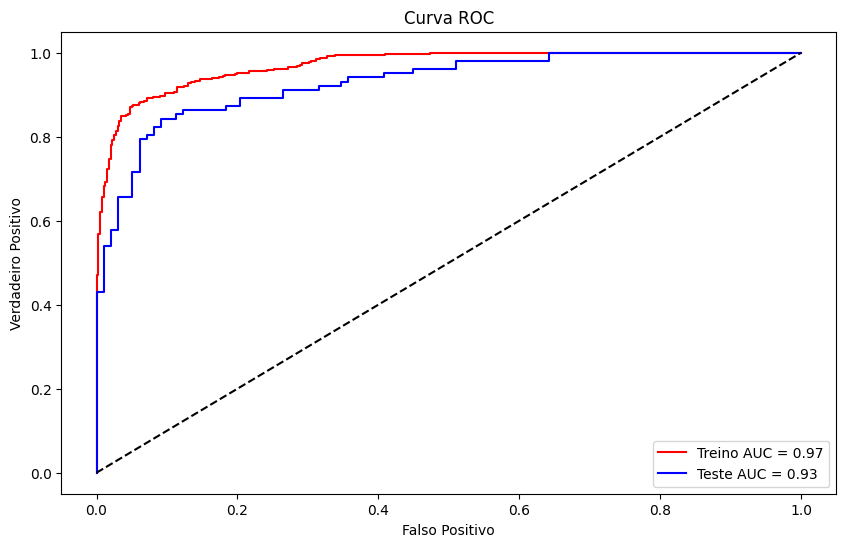

In [23]:
def avalia(modelo, X_train, y_train, X_test, y_test):
    p_train = modelo.predict_proba(X_train)[:, 1]
    # c_train = modelo.predict(X_train)
    
    p_test = modelo.predict_proba(X_test)[:, 1]
    # c_test = modelo.predict(X_test)

    auc_train = roc_auc_score(y_train, p_train)
    auc_test = roc_auc_score(y_test, p_test)
    
    print(f'Avaliação base de treino: AUC = {auc_train:.2f}')
    print(f'Avaliação base de teste: AUC = {auc_test:.2f}')
    
    fpr_train, tpr_train, _ = roc_curve(y_train, p_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, p_test)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr_train, tpr_train, color='red', label=f'Treino AUC = {auc_train:.2f}')
    plt.plot(fpr_test, tpr_test, color='blue', label=f'Teste AUC = {auc_test:.2f}')
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.xlabel('Falso Positivo')
    plt.ylabel('Verdadeiro Positivo')
    plt.title('Curva ROC')
    plt.legend()
    plt.show()

avalia(grid_search.best_estimator_, X_train, y_train, X_test, y_test)


Previsão

In [29]:
grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=2360873, ...)